<a href="https://colab.research.google.com/github/uol-mediaprocessing-2021-2022/students_projects-can-i-read-it/blob/dev-niklas2/can%2BI%2Bread%2Bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


STUFF TODO
- test other line detection
- document stuff we tested !

In [2]:
# Output to colab (Source: Lecture)
import matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

The inbuilt version of OpenCV in Colab seems to lack the GPU acceleration support (at least when attempting to set the preferable backend to CUDA using:
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA))

To deal with this the recent OpenCV version must be copied and the needed files extracted.

In [3]:
# Source: https://towardsdatascience.com/how-to-use-opencv-with-gpu-on-colab-25594379945f
# ONLY RUN THIS CELL IF YOU NEED CUDA ACCELERATION FOR OPENCV ! 
# %cd /content
# !git clone https://github.com/opencv/opencv
# !git clone https://github.com/opencv/opencv_contrib
# !mkdir /content/build
# %cd /content/build
# !cmake -DOPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules  -DBUILD_SHARED_LIBS=OFF  -DBUILD_TESTS=OFF  -DBUILD_PERF_TESTS=OFF -DBUILD_EXAMPLES=OFF -DWITH_OPENEXR=OFF -DWITH_CUDA=ON -DWITH_CUBLAS=ON -DWITH_CUDNN=ON -DOPENCV_DNN_CUDA=ON /content/opencv
# !make -j8 install

In [4]:
# Copy the CUDA acceleration file to gdrive for further usage
# !mkdir  "/content/gdrive/My Drive/cv2_gpu"
# !cp  /content/build/lib/python3/cv2.cpython-36m-x86_64-linux-gnu.so   "/content/gdrive/My Drive/cv2_gpu"

In [5]:
# Import making it possible to use GPU acceleration
!cp "/content/drive/My Drive/cv2_gpu/cv2.cpython-37m-x86_64-linux-gnu.so" .
import cv2 as cv
cv.__version__

'4.5.4-dev'

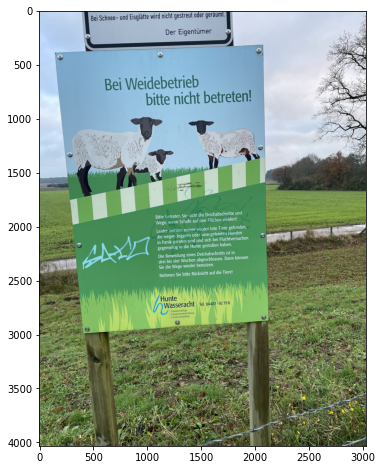

In [6]:
# Set image
img = cv.imread('/content/drive/My Drive/IMG_5406.png')

# Create a list to store all preprocessed versions
preprocessed_list = {}
# create a list that stores strings describing all preprocessed versions
preprocessed_names_list = {}

# Add the original image to the list
preprocessed_list[0] = cv.cvtColor(img, cv.COLOR_BGR2RGB)
preprocessed_names_list[0] = "RGB"

plt.figure(figsize=(8, 8))
plt.imshow(preprocessed_list[0])

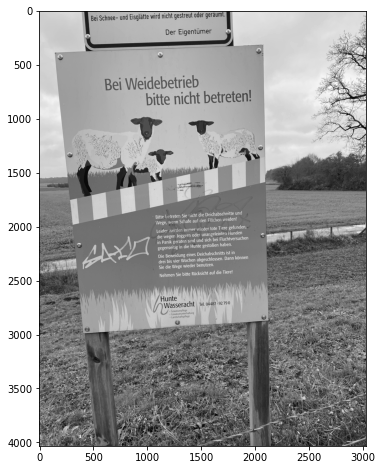

In [7]:
# Create a greyscale copy
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Output image
fig = plt.figure(figsize=(8,8))
plt.imshow(img_gray, cmap = "gray")

# Add greyscale copy to preprocessed List
img_gray = cv.merge((img_gray,img_gray,img_gray)) # Hack for 3 gray channels
preprocessed_list[1] = img_gray
preprocessed_names_list[1] = "Grayscale"


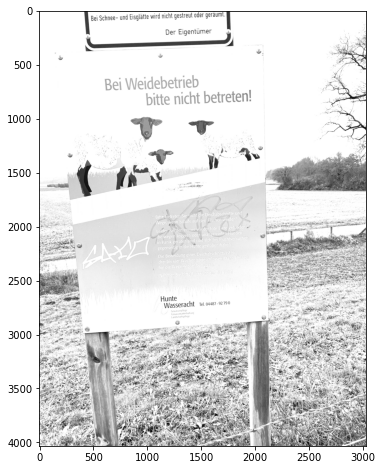

In [8]:
alpha = 2 # Contrast
beta = 0 # Brightness

# Change contrast (grayscale)
img_gray_highK = cv.convertScaleAbs(img_gray, alpha=alpha, beta=beta)

# Show plot
plt.figure(figsize=(8,8))
plt.imshow(img_gray_highK, cmap='gray')

# Add high contrast greyscale copy to preprocessed list
preprocessed_list[2] = img_gray_highK
preprocessed_names_list[2] = "Grayscale high contrast"

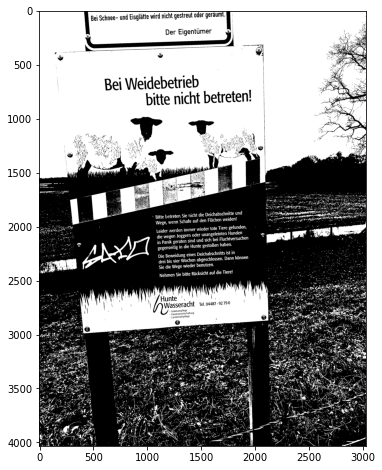

In [9]:
# Create a binary copy using "smart" thresholding

th, img_bin = cv.threshold(cv.cvtColor(img, cv.COLOR_BGR2GRAY),0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Output image
fig = plt.figure(figsize=(8,8))
plt.imshow(img_bin, cmap = "gray")

img_bin = cv.merge((img_bin, img_bin, img_bin)) # Hack for 3 gray channels

# Add binary copy to preprocessed List
preprocessed_list[3] = img_bin
preprocessed_names_list[3] = "Binary with OTSU"

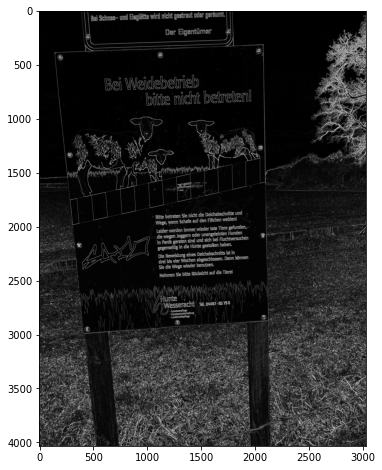

In [10]:
# Apply edge-detection using sobel filter on the grayscale picture
scale = 1
delta = 0
ddepth = cv.CV_16S
# Reduce noise using gaussian blur
src = cv.GaussianBlur(img, (3, 3), 0)
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# gradient in x direction
grad_x = cv.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
# gradient in direction 
grad_y = cv.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    
abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)
    
grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

grad = cv.merge((grad, grad, grad)) # Hack for 3 gray channels

preprocessed_list[4] = grad
preprocessed_names_list[4] = "Sobel + Gauss"

fig = plt.figure(figsize=(8,8))
plt.imshow(grad, cmap = "gray")


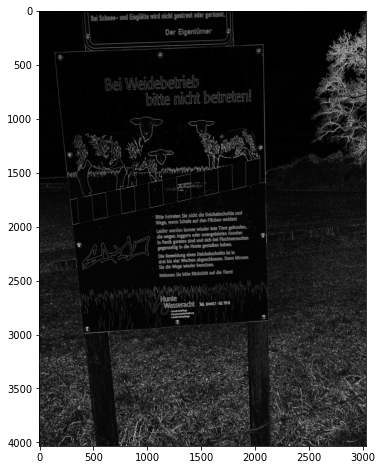

In [11]:
# Apply edge-detection using laplacian filter on grayscale picture
# source : https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html

ddepth = cv.CV_16S
kernel_size = 3
# the original bgr-picture was already blurred and converted to grayscale for edge-detection with sobel  
# we can now apply the laplace function to this picture
dst = cv.Laplacian(gray, ddepth, ksize = kernel_size)
dst = cv.convertScaleAbs(dst)

dst = cv.merge((dst, dst, dst)) # hack for 3 gray channels

preprocessed_list[5] = dst
preprocessed_names_list[5] = "Laplace + Gauss"

fig = plt.figure(figsize=(8,8))
plt.imshow(dst, cmap = "gray")

In [12]:
# Plot histograms for the pictures in the processing list
# source: https://docs.opencv.org/3.4/d8/dbc/tutorial_histogram_calculation.html
histsize = 256
histrange = [0, histsize]

fig = plt.figure(figsize=(45, 10)) 
# Histogram for BGR
ax1 = fig.add_subplot(1, len(preprocessed_list), 1)
ax1.title.set_text('BGR')
bgr_planes = cv.split(img)

hist_b = cv.calcHist([bgr_planes[0]],[0],None,[histsize],histrange)
hist_b = hist_b / hist_b.sum()
hist_g = cv.calcHist([bgr_planes[1]],[0],None,[histsize],histrange)
hist_g = hist_g / hist_g.sum()
hist_r = cv.calcHist([bgr_planes[2]],[0],None,[histsize],histrange)
hist_r = hist_r / hist_r.sum()
plt.xlim([0, 256])
plt.ylim([0,0.05])
plt.plot(hist_b,'b')
plt.plot(hist_g,'g')
plt.plot(hist_r,'r')

# histogram for grayscale
ax2 = fig.add_subplot(1, len(preprocessed_list), 2)
hist_gray = cv.calcHist([img_gray],[0],None,[histsize],histrange)
hist_gray = hist_gray / hist_gray.sum()
ax2.title.set_text(preprocessed_names_list[1])
plt.ylim([0,0.04])
plt.plot(hist_gray,'gray')

# histogram for grayscale high contrast
ax3 = fig.add_subplot(1, len(preprocessed_list), 3)
hist_gray_hc = cv.calcHist([img_gray_highK],[0],None,[histsize],histrange)
hist_gray_hc  = hist_gray_hc / hist_gray_hc.sum()
ax3.title.set_text(preprocessed_names_list[2])
plt.ylim([0,0.04])
plt.plot(hist_gray_hc,'gray')

# histogram for binary
ax4 = fig.add_subplot(1, len(preprocessed_list), 4)
hist_bin = cv.calcHist([img_bin],[0],None,[histsize],histrange)
hist_bin = hist_bin / hist_bin.sum()
ax4.title.set_text(preprocessed_names_list[3])
plt.ylim([0,0.8])
plt.plot(hist_bin,'black') 

# histogram for sobel
ax5 = fig.add_subplot(1, len(preprocessed_list), 5)
hist_grad = cv.calcHist([grad],[0],None,[histsize],histrange)
hist_grad = hist_grad / hist_grad.sum()
ax5.title.set_text(preprocessed_names_list[4])
plt.plot(hist_grad, 'gray')

# histogram for laplace
ax6 = fig.add_subplot(1, len(preprocessed_list), 6)
hist_dst = cv.calcHist([dst],[0],None,[histsize],histrange)
hist_dst = hist_dst / hist_dst.sum()
ax6.title.set_text(preprocessed_names_list[5])
plt.plot(hist_dst, 'gray')

In [17]:
# Use EAST 
# Source: https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
from imutils.object_detection import non_max_suppression
import time

# Create list that will contain cordinates of found text boxes for each image
boxes_list = []

# Set min confidence for text detection
min_score = 0.99 # Adjustable

# Set scaling resolution, must be multiple of 32 for EAST
res = 1280 # 1280x1280 works good

# Figure containing output images
fig = plt.figure(figsize=(45,20))


for index, img_idx in enumerate(preprocessed_list):
	# Create copy and grab image dimensions
	orig = preprocessed_list[img_idx].copy()
	orig_rectangles = preprocessed_list[img_idx].copy()
	(H, W) = orig.shape[:2]

	# Adjust image dimensions
	(newW, newH) = (res, res)
	rW = W / float(newW)
	rH = H / float(newH)

	preprocessed_img = cv.resize(preprocessed_list[img_idx], (newW, newH))
	(H, W) = preprocessed_img.shape[:2]

	# 2 layers are needed, the confiidences of the predictions and koordinates of found Text
	layerNames = [
		"feature_fusion/Conv_7/Sigmoid",
		"feature_fusion/concat_3"]

	# Load EAST
	print("[INFO] Initializing text detection with EAST [" + str(index + 1) + "/" + str(len(preprocessed_list)) + "]")
	net = cv.dnn.readNet('/content/drive/My Drive/east/frozen_east_text_detection.pb')
	# net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
	# net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)

	# Create a "blob" and generate output using the trained model
	blob = cv.dnn.blobFromImage(preprocessed_img, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)
	start = time.time()
	net.setInput(blob)
	(scores, geometry) = net.forward(layerNames)
	end = time.time()

	print("[INFO] text detection took {:.6f} seconds".format(end - start))
 
	# Grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# Iterate the rows
	for y in range(0, numRows):
		# Extract the scores alongside the cordinates of found text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# Iterate columns
		for x in range(0, numCols):
			# Ignore scores below the threshold
			if scoresData[x] < min_score:
				continue
			# Calculate offset factor as our resulting feature maps will
			# be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			# Calculate rotation angle
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			# Calculate width and height of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			# Caclulate cordinates of the bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			# Add the bounding box coordinates and probability score to
			# our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
		
	# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
	boxes = non_max_suppression(np.array(rects), probs=confidences)

	# Iterate all boxes of an image
	for (startX, startY, endX, endY) in boxes:
		# Rescale the boxes
		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)
		# Draw boxes in output image
		cv.rectangle(orig_rectangles, (startX, startY), (endX, endY), (0, 255, 0), 3)

	# Add boxes to list containing all boxes for an image
	boxes_list.append(boxes)

	# Add output image to plot
	fig.add_subplot(2, 3, index+1).title.set_text(preprocessed_names_list[index])
	plt.imshow(orig_rectangles, cmap='gray', aspect='auto')

# Display plot
plt.show()

[INFO] Initializing text detection with EAST [1/6]
[INFO] text detection took 6.406439 seconds
[INFO] Initializing text detection with EAST [2/6]
[INFO] text detection took 6.694360 seconds
[INFO] Initializing text detection with EAST [3/6]
[INFO] text detection took 6.277483 seconds
[INFO] Initializing text detection with EAST [4/6]
[INFO] text detection took 6.726413 seconds
[INFO] Initializing text detection with EAST [5/6]
[INFO] text detection took 6.405063 seconds
[INFO] Initializing text detection with EAST [6/6]
[INFO] text detection took 6.634029 seconds


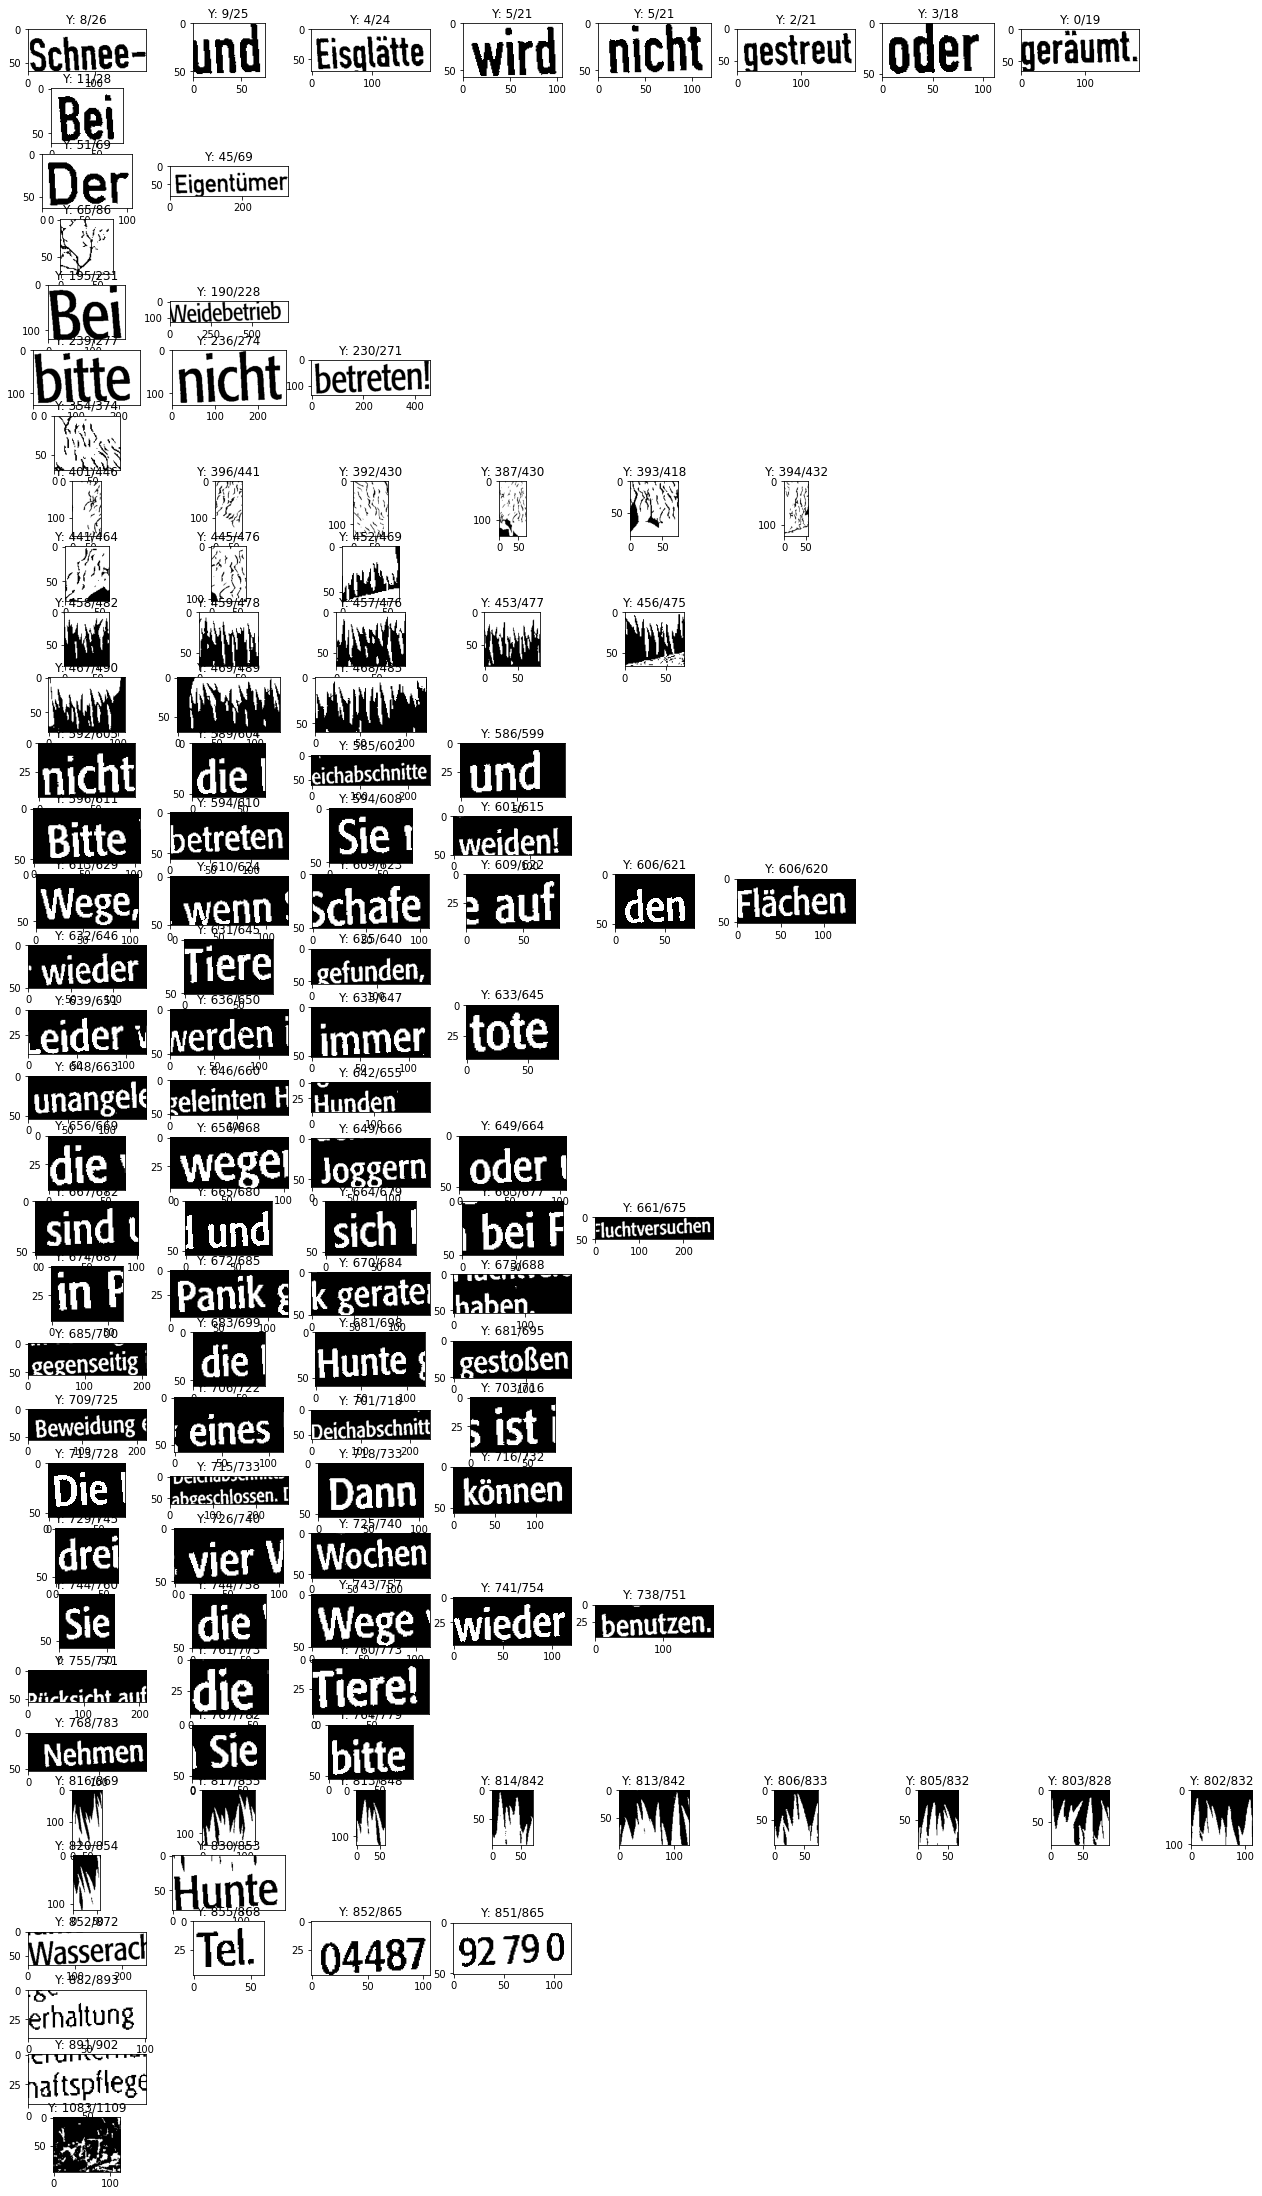

In [14]:
img_index = 3 # Set index of image used for text position detection
margin = 7 # To account for inaccuracy set amount to increase each boundary by

# Create figure that will contain all cropped text areas (boxes)
fig = plt.figure(figsize=(25, 60))

# Method for getting the center of a bounding box
def get_center(box):
  center_x = (box[0] + box[2]) / 2
  center_y = (box[1] + box[3]) / 2
  return int(center_x), int(center_y)

# Check if any text was found before proceeding
if len(boxes_list[img_index]) == 0:
  raise SystemExit("List is empty")

# Sort each boxes array
sorted_boxes = []

rect_list = boxes_list[img_index].tolist()
rect_list = sorted(rect_list, key=lambda k: [k[1], k[0]])

row = []

# Find all words within the same line and append them into a list
while(len(rect_list) > 0):

  for rect in rect_list:
    if len(rect_list) > 0:

      y_new = get_center(rect_list[0])[1]
      y_range = range(rect[1], rect[3])

      if y_new in y_range:
        row.append(rect)
      
  rect_list = [i for i in rect_list if i not in row] 
     
  rect_list = sorted(rect_list, key=lambda k: [k[1], k[0]])
  row = sorted(row, key=lambda k: [k[0], k[1]])
  sorted_boxes.append(row)
  row = []

# Crop all found boxes and plot them
for index, elem in enumerate(sorted_boxes):
  for index2, (startX, startY, endX, endY)  in enumerate(elem):
    cropped_img = preprocessed_list[img_index]
    # Calculate extended margins, respect image bounds
    y_start =  int(startY * rH - margin) if int(startY * rH - margin) >= cropped_img.shape[1] else int(startY * rH)
    y_end = int(endY * rH + margin) if int(endY * rH + margin) <= cropped_img.shape[1] else int(endY * rH + margin)
    x_start = int(startX * rW - margin) if int(startX * rW - margin) >= cropped_img.shape[0] else int(startX * rW)
    x_end = int(endX * rW + margin) if int(endX * rW + margin) <= cropped_img.shape[0] else int(endX * rW)

    cropped_img = cropped_img[y_start:y_end, x_start:x_end]
    ax = fig.add_subplot(50, 10, index2+1+index*10)
    ax.title.set_text('Y: ' + str(startY) + '/' + str(endY))

    plt.imshow(cropped_img)


# Show cropped text 
plt.show()

In [15]:
# Install English and German tesseract
!sudo apt install tesseract-ocr tesseract-ocr-deu 
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
tesseract-ocr-deu is already the newest version (4.00~git24-0e00fe6-1.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


Problem: Tesseract benötigt schwarzes Text auf klaren, weißen Hintergrund


Lösung: Erstelen von ein Binärbild und evtl. Inversion von Schwarz und Weiß.

In [16]:
# Source for Tesseract config and usage: https://jaafarbenabderrazak-info.medium.com/opencv-east-model-and-tesseract-for-detection-and-recognition-of-text-in-natural-scene-1fa48335c4d1
# Recognize text using tesseract 
import pytesseract

tes_preprocess = img.copy()

# Method for preprocessing the image for tesseract usage
def preprocess_tsrct(imge):
  scale_percent = 100 # percent of original size
  width = int(imge.shape[1] * scale_percent / 100)
  height = int(imge.shape[0] * scale_percent / 100)
  dim = (width, height)
    
  # Resize image
  resized = cv.resize(imge, dim, interpolation = cv.INTER_AREA)
  gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
  processed = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

  # Make sure that black text is on white background
  w_pix_num = np.sum(processed == 255)
  b_pix_num = np.sum(processed == 0)
  if b_pix_num > w_pix_num:
    processed = cv.bitwise_not(processed)
  
  # Smoothen the background to reduce noise
  processed = cv.GaussianBlur(processed, (3,3), 0) 
  return processed

results = []

for index, elem in enumerate(sorted_boxes):
  curr_row = ""
  for index2, (startX, startY, endX, endY) in enumerate(elem):
    
    # Calculate extended margins, respect image bounds  
    y_start =  int(startY * rH - margin) if int(startY * rH - margin) >= tes_preprocess.shape[1] else int(startY * rH)
    y_end = int(endY * rH + margin) if int(endY * rH + margin) <= tes_preprocess.shape[1] else int(endY * rH + margin)
    x_start = int(startX * rW - margin) if int(startX * rW - margin) >= tes_preprocess.shape[0] else int(startX * rW)
    x_end = int(endX * rW + margin) if int(endX * rW + margin) <= tes_preprocess.shape[0] else int(endX * rW)

    cropped_img = tes_preprocess[y_start:y_end, x_start:x_end]
    cropped_img = preprocess_tsrct(cropped_img)

    # Configuration setting to convert image to string   <<- Check other CONFIG
    configuration = ("-l deu+eng --oem 1 --psm 8")  

    # This will recognize the text from the image of bounding box
    d = pytesseract.image_to_data(cropped_img, output_type=pytesseract.Output.DICT, config=configuration)

    # Get the highest confidence among the recognized words
    conf_list = [int(x) for x in d['conf']]
    max_conf = max(conf_list)

    # Filter text with too low detection confidences
    if max_conf >= 50:
      max_conf_idx = d['conf'].index(max_conf) 
      text = d['text'][max_conf_idx]
    else:
      text = ""

    # Append detected text to current line of text
    curr_row = curr_row + " " + text

  # Append line to the list of detected lines
  results.append(curr_row)

for txt in results:
  print("{}\n".format(txt), end = " ")

 Schnee- und Fisalatte wird nicht gestreut oder geräumt.
  Bei
  Der Eigentümer
  
  Bei \NeidebetrieD
  bitte nicht betreten!
  
  4  N   
    
      
   NEM 
  nicht die eichabschnitte und
  Bitte betreten Sie weiden!
  Wege, | Schafe > den Flächen
  wieder Tiere gefunden,
  -eider | immer tote
  unangele H Hunden
  die wege: Joggern oder
  sind und sich F 
  inf Panik k 
  | die Hunte gestoßen
  Beweidung eines. Deichabschnitt |
  Die [ Dann 
  drei V Wochen
  Sie die Wege wieder benutzen.
  art die Tiere!
   Sie bitte
   ul  WW, Al   Wi 
  N Hunte
  \Nasserach Tel. 04487 92790
  
  
  
 